In [1]:
import sys
import os
import json
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx 

# Add path
sys.path.append(os.path.abspath("./"))

# IMPORT MODULES
import GA as ga_ops
from GA_setup import multi_obj_GA
from pulse_generator_problem import PulseGenerator

print("Libraries loaded.")

Loaded 12 Activators and 12 Inhibitors.
Libraries loaded.


In [2]:

# CONFIGURATION: FREE SEARCH

# 1. Use the NEW settings file
SETTINGS_FILE = "FreeSearch_settings.json" 

with open(SETTINGS_FILE, "r") as f:
    settings = json.load(f)

# Output Folder
timestamp = datetime.datetime.now().strftime("%Y-%m-%d")
phys_tag = "FreeSearch_DsRed" 
OUTPUT_FOLDER = f"results/Miner_{phys_tag}_{timestamp}"

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

print(f"--- FREE SEARCH CONFIGURATION ---")
print(f"Generations:   {settings['n_gen']}")
print(f"Population:    {sum(settings['num_dict'].values())} circuits")
print(f"Output:        {OUTPUT_FOLDER}")

--- FREE SEARCH CONFIGURATION ---
Generations:   100
Population:    200 circuits
Output:        results/Miner_FreeSearch_DsRed_2026-02-12


### Modified GCAD Execution Block 
(**Note** : Careful to re-run)

In [ ]:
# 1. Initialize Problem
problem = PulseGenerator(
    promo_node=settings["promo_node"],
    dose_specs=settings["dose_specs"],
    max_part=settings["max_part"],
    inhibitor=settings["inhibitor"],
    DsRed_inhibitor=settings["DsRed_inhibitor"],
    num_dict=settings["num_dict"],
    n_gen=settings["n_gen"],
    probability_crossover=settings["probability_crossover"],
    probability_mutation=settings["probability_mutation"],
    mutate_dose=settings["mutate_dose"],
    pop=settings["pop"],
    obj_labels=settings["obj_labels"],
    max_time=settings["max_time"]
)

# 2. Sample Generation 0
print("Sampling Initial Population...")
population = ga_ops.sampling(problem.promo_node, problem.num_dict, problem.min_dose, 
                             problem.max_dose, problem.dose_interval, problem.inhibitor)

# 3. Evaluate Generation 0
obj = np.asarray([problem.func(ind[0]) for ind in population])

# 4. Run Evolution
num_circuits = int(sum(settings["num_dict"].values()))
print(">> STARTING EVOLUTION...")

multi_obj_GA(
    folder_path=OUTPUT_FOLDER,
    problem=problem,
    population=population,
    num_circuits=num_circuits,
    obj=obj,
    get_unique=False,
    plot=False
)
print(">> EVOLUTION DONE.")

### Result Analysis

Loaded 200 Final Winners and 4814 History Records.
Analyzing 200 Valid Pulse Generators.

SPECIFIC TOPOLOGY PREVALENCE
Found 10 Unique Specific Topologies.
Top 3:
  Rank 0: 117 circuits (58.5%)
  Rank 1: 37 circuits (18.5%)
  Rank 2: 16 circuits (8.0%)


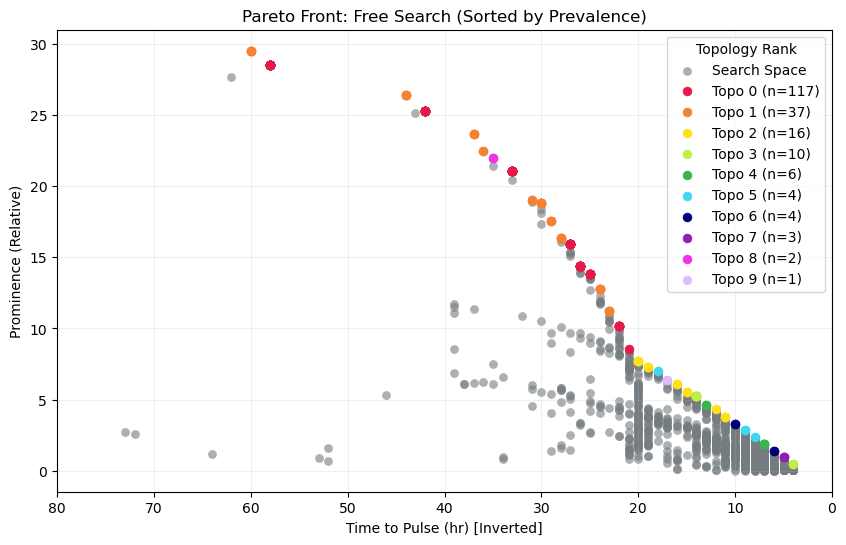

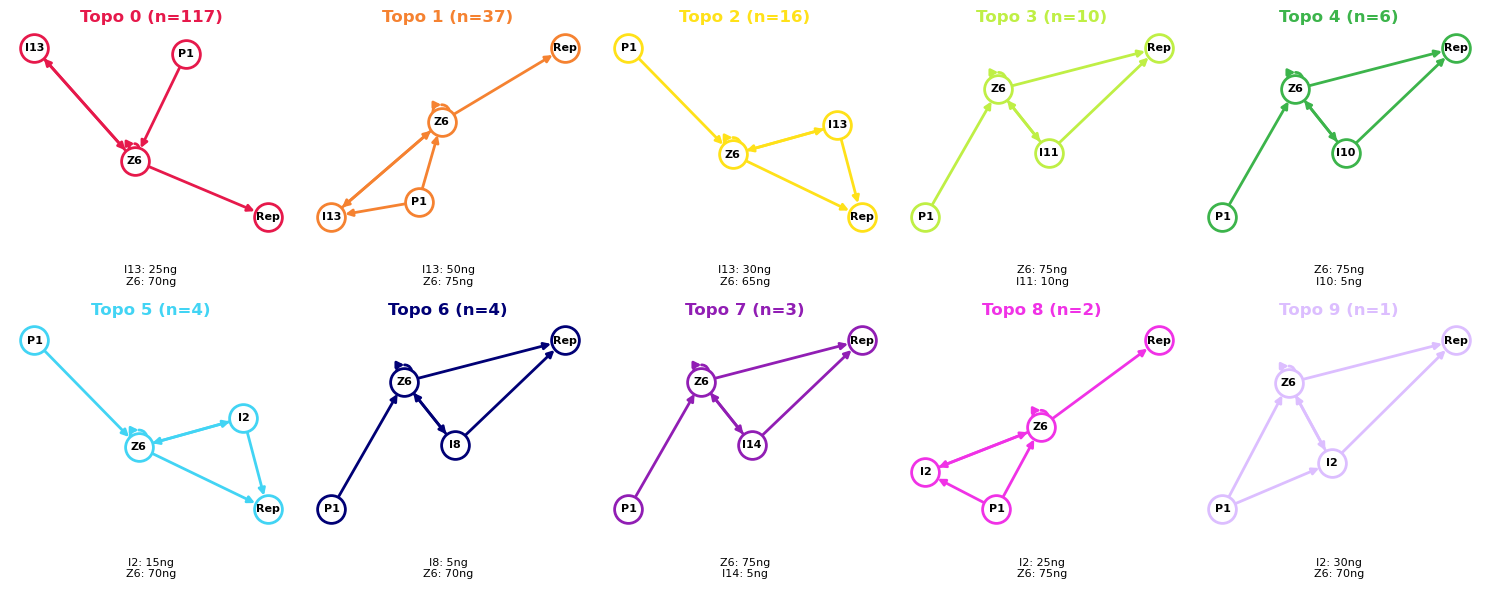

In [4]:
# 1. CONFIGURATION & LOADING

RESULTS_FOLDER = "results/Miner_FreeSearch_DsRed_2026-02-11" # <--- CHECK PATH

# Color Palette for Specific Topologies
TOPO_COLORS = ['#e6194B', '#f58231', '#ffe119', '#bfef45', '#3cb44b', '#42d4f4', '#000075', "#911eb4", "#f032e6", '#dcbeff', "#000000"]

def load_and_process_data(folder):
    """Loads miner results and prepares DataFrame with signatures."""
    try:
        # Load Files
        df = pd.read_pickle(f"{folder}/final_objectives_df.pkl")
        with open(f"{folder}/final_population.pkl", "rb") as f:
            pop = pickle.load(f)
        hist_df = pd.read_pickle(f"{folder}/unique_objectives_df.pkl")
        
        print(f"Loaded {len(pop)} Final Winners and {len(hist_df)} History Records.")
        
        # 1. Attach Circuit Objects & Fix Signs
        df['circuit_object'] = [ind[0] for ind in pop]
        df['prominence_rel'] = -df['prominence_rel'] # Min -> Max
        hist_df['prominence_rel'] = -hist_df['prominence_rel']
        
        # 2. Generate Signatures
        # Specific: Exact parts (e.g., Z6, I13)
        df['topology_sig'] = df['circuit_object'].apply(lambda c: str(tuple(sorted(c.edge_list))))
        
        # Abstract: Generic Roles (Input, A, R, Output)
        df['abstract_sig'] = df['circuit_object'].apply(lambda c: abstract_edges(c.edge_list))
        
        return df, hist_df
        
    except FileNotFoundError:
        print(f"Error: Could not find results in {folder}")
        return None, None

def abstract_edges(edge_list):
    """Maps specific parts to generic roles (Input, Output, Activator, Repressor)."""
    generic = []
    for u, v in edge_list:
        src = 'P1' if u == 'P1' else ('A' if u.startswith('Z') else ('R' if u.startswith('I') else u))
        tgt = 'Rep' if v == 'Rep' else ('A' if v.startswith('Z') else ('R' if v.startswith('I') else v))
        generic.append((src, tgt))
    return tuple(sorted(generic))

# LOAD DATA
final_df, history_df = load_and_process_data(RESULTS_FOLDER)

# FILTER VALID PULSES
if final_df is not None:
    valid_df = final_df[final_df['prominence_rel'] > 0.1].copy()
    print(f"Analyzing {len(valid_df)} Valid Pulse Generators.")

# 2. ANALYSIS: SPECIFIC TOPOLOGIES (Prevalence)

if final_df is not None and not valid_df.empty:
    print("\n" + "="*40)
    print("SPECIFIC TOPOLOGY PREVALENCE")
    print("="*40)

    # Count & Sort
    topo_counts = valid_df['topology_sig'].value_counts()
    sorted_sigs = topo_counts.index.tolist()
    
    # Map Colors based on Rank
    sig_to_id = {sig: i for i, sig in enumerate(sorted_sigs)}
    sig_to_color = {sig: TOPO_COLORS[i % len(TOPO_COLORS)] for i, sig in enumerate(sorted_sigs)}
    
    valid_df['color'] = valid_df['topology_sig'].map(sig_to_color)
    valid_df['topo_id'] = valid_df['topology_sig'].map(sig_to_id)
    
    # Print Stats
    print(f"Found {len(sorted_sigs)} Unique Specific Topologies.")
    print(f"Top 3:")
    for i in range(min(3, len(sorted_sigs))):
        sig = sorted_sigs[i]
        count = topo_counts[sig]
        print(f"  Rank {i}: {count} circuits ({count/len(valid_df):.1%})")

    # --- PLOT 1: PARETO FRONT (Sorted) ---
    plt.figure(figsize=(10, 6))
    
    # Grey Cloud
    plt.scatter(history_df['t_pulse'], history_df['prominence_rel'], 
                c="#757c80", s=40, alpha=0.6, linewidths=0, label='Search Space')
    
    # Winners
    for sig in sorted_sigs:
        subset = valid_df[valid_df['topology_sig'] == sig]
        tid = sig_to_id[sig]
        count = topo_counts[sig]
        color = sig_to_color[sig]
        plt.scatter(subset['t_pulse'], subset['prominence_rel'], 
                    c=color, s=40, alpha=1.0, linewidth=0.5, zorder=10,
                    label=f"Topo {tid} (n={count})")
    
    plt.xlim(0, 80)
    plt.gca().invert_xaxis()
    plt.xlabel("Time to Pulse (hr) [Inverted]")
    plt.ylabel("Prominence (Relative)")
    plt.title("Pareto Front: Free Search (Sorted by Prevalence)")
    if len(sorted_sigs) < 15: plt.legend(title="Topology Rank", loc='upper right')
    plt.grid(True, alpha=0.2)
    plt.show()

    # --- PLOT 2: SPECIFIC SCHEMATICS ---
    num = len(sorted_sigs)
    cols = min(num, 5)
    rows = (num // cols) + (1 if num % cols > 0 else 0)
    
    if rows > 0:
        fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
        if num == 1: axes = [axes]
        axes = np.array(axes).flatten()
        
        for i, sig in enumerate(sorted_sigs):
            ax = axes[i]
            rep_row = valid_df[valid_df['topology_sig'] == sig].sort_values('prominence_rel', ascending=False).iloc[0]
            rep_circuit = rep_row['circuit_object']
            color = sig_to_color[sig]
            count = topo_counts[sig]
            
            G = nx.DiGraph(rep_circuit.edge_list)
            pos = nx.spring_layout(G, seed=25)
            nx.draw(G, pos, ax=ax, node_color='white', edgecolors=color, linewidths=2, node_size=400, 
                    with_labels=True, font_weight='bold', font_size=8, edge_color=color, width=2, arrowsize=10)
            
            ax.set_title(f"Topo {i} (n={count})", color=color, fontweight='bold', fontsize=12)
            dose_str = "\n".join([f"{k}: {v}ng" for k, v in rep_circuit.dose.items() if k!='Rep'])
            ax.text(0.5, -0.15, dose_str, transform=ax.transAxes, ha='center', va='top', fontsize=8)
            
        for j in range(i+1, len(axes)): axes[j].axis('off')
        plt.tight_layout()
        plt.show()



 CIRCUIT ARCHITECTURES (Paper Validation)
                                                                              Architecture  Count Proportion  Variants Max_Prominence
                           (('A', 'A'), ('A', 'R'), ('A', 'Rep'), ('P1', 'A'), ('R', 'A'))    117      58.5%         1          28.49
             (('A', 'A'), ('A', 'R'), ('A', 'Rep'), ('P1', 'A'), ('R', 'A'), ('R', 'Rep'))     43      21.5%         6           7.71
              (('A', 'A'), ('A', 'R'), ('A', 'Rep'), ('P1', 'A'), ('P1', 'R'), ('R', 'A'))     39      19.5%         2          29.53
(('A', 'A'), ('A', 'R'), ('A', 'Rep'), ('P1', 'A'), ('P1', 'R'), ('R', 'A'), ('R', 'Rep'))      1       0.5%         1           6.41

Visualizing Dominant Architectures (Generic Wiring):


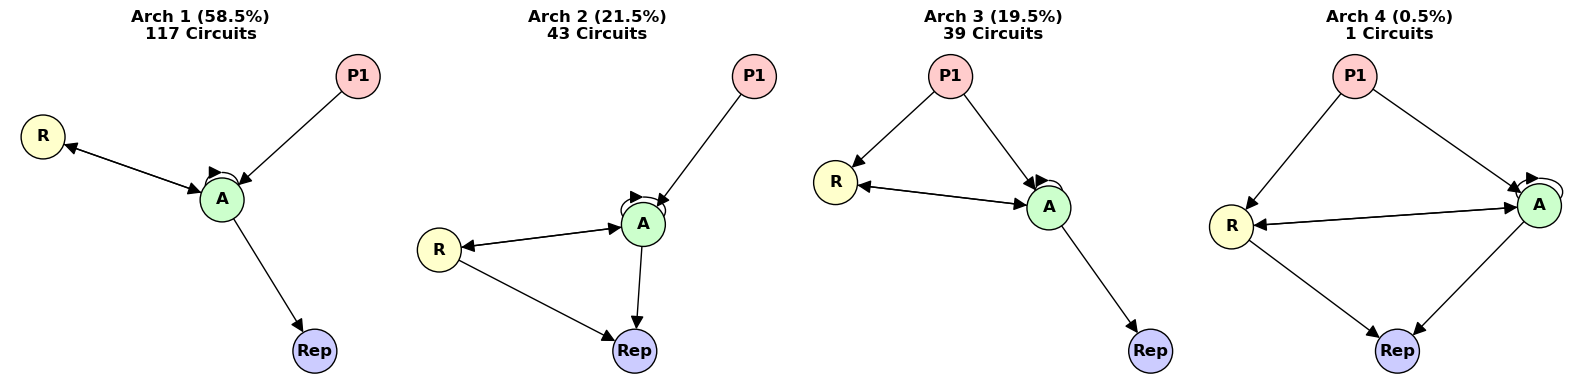

In [5]:

# 3. ANALYSIS: PURE (ABSTRACT) ARCHITECTURES

if final_df is not None and not valid_df.empty:
    print("\n" + "="*40)
    print(" CIRCUIT ARCHITECTURES (Paper Validation)")
    print("="*40)
    
    # Group by Abstract Signature
    abs_counts = valid_df['abstract_sig'].value_counts().reset_index()
    abs_counts.columns = ['abstract_sig', 'Count']
    abs_counts['Proportion'] = abs_counts['Count'] / len(valid_df)
    
    # Generate Stats Table
    arch_stats = []
    for arch in abs_counts['abstract_sig']:
        subset = valid_df[valid_df['abstract_sig'] == arch]
        arch_stats.append({
            'Architecture': str(arch),
            'Count': len(subset),
            'Proportion': f"{len(subset)/len(valid_df):.1%}",
            'Variants': subset['topology_sig'].nunique(),
            'Max_Prominence': f"{subset['prominence_rel'].max():.2f}"
        })
    
    print(pd.DataFrame(arch_stats).to_string(index=False))
    
    # --- PLOT 3: ABSTRACT SCHEMATICS ---
    top_archs = abs_counts.head(4)
    fig, axes = plt.subplots(1, len(top_archs), figsize=(4 * len(top_archs), 4))
    if len(top_archs) == 1: axes = [axes]
    
    print("\nVisualizing Dominant Architectures (Generic Wiring):")
    for i, (_, row) in enumerate(top_archs.iterrows()):
        ax = axes[i]
        G = nx.DiGraph(row['abstract_sig'])
        pos = nx.spring_layout(G, seed=25)
        
        # Generic Colors
        nc = []
        for n in G.nodes():
            if n=='P1': nc.append('#ffcccc')
            elif n=='Rep': nc.append('#ccccff')
            elif n=='A': nc.append('#ccffcc')
            elif n=='R': nc.append('#ffffcc')
            else: nc.append('lightgray')
            
        nx.draw(G, pos, ax=ax, with_labels=True, node_color=nc, node_size=1000, 
                font_weight='bold', arrowsize=20, edgecolors='black')
        ax.set_title(f"Arch {i+1} ({row['Proportion']:.1%})\n{row['Count']} Circuits", fontweight='bold')
        
    plt.tight_layout()
    plt.show()